## Twitter Sentiment Investing Strategy

### 1. Load Twitter Sentiment Data  
* Load the Twitter sentiment dataset, set the index, calculate engagement ratio and filter out stocks with no significant twitter activity

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = 'E:/projects/twitter-sentiment-investing-strategy'

sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments'] / sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes'] > 20) & (sentiment_df['twitterComments'] > 10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

### 2. Aggregate Monthly and Calculate Average Monthly Sentiment
* Aggregate on a monthly level and calculate average monthly metric  

In [78]:
aggregated_df = sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='ME'), 'symbol'])[['engagement_ratio']].mean()

aggregated_df['rank'] = aggregated_df.groupby(level='date')['engagement_ratio'].rank(ascending=False)

aggregated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

### 3. Select Top 5 Stocks Based on their Cross-Sectional Ranking for Each Month
* Select top 5 stocks by rank for each month and fix the date to start at the beginning of the month

In [79]:
filtered_df = aggregated_df[aggregated_df['rank'] <= 5]

filtered_df = filtered_df.reset_index(level='symbol')

filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
...                             ...   ...
2023-02-01 A               0.471572   5.0
           AES             0.533809   4.0
           BIIB            0.839303   1.0
           FCX             0.667387   3.0
           MDT             0.806841   2.0

[75 rows x 2 columns]

### 4. Extract the stocks to form portfolios with at the start of each month
* Create a dictionary containing start of the month and corresponding selected stocks

In [80]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

### 5. Download Fresh Stock Prices

In [81]:
stocks_list = filtered_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-12-01',
                        end='2023-03-01')

prices_df

[*********************100%%**********************]  34 of 34 completed


Price        Adj Close                                                \
Ticker               A         ABT        AEP        AES         AMD   
Date                                                                   
2021-12-01  145.480072  120.377350  72.360733  21.556053  149.110001   
2021-12-02  148.208878  121.935020  73.289124  22.013138  150.679993   
2021-12-03  146.579437  123.730141  74.217522  21.720602  144.009995   
2021-12-06  148.680008  125.819710  75.254082  22.269104  139.059998   
2021-12-07  150.967102  125.772186  75.632652  22.689619  144.850006   
...                ...         ...        ...        ...         ...   
2023-02-22  140.565475   99.620407  85.452393  24.015274   76.610001   
2023-02-23  141.673508   99.484596  85.348892  24.015274   79.750000   
2023-02-24  139.694855   97.457062  85.085449  23.949064   78.089996   
2023-02-27  140.664368   96.787689  84.746719  23.532887   78.769997   
2023-02-28  140.456635   98.679398  82.770836  23.343719   78.580002   

Price                                                                  ...  \
Ticker            BIIB          CB         CRM         CVX          D  ...   
Date                                                                   ...   
2021-12-01  229.500000  167.611069  250.781540  100.829880  62.548817  ...   
2021-12-02  228.520004  174.520691  260.453827  103.564240  63.991840  ...   
2021-12-03  223.919998  173.659393  257.582062  102.907646  65.060753  ...   
2021-12-06  224.110001  179.468445  258.010834  104.517670  66.174187  ...   
2021-12-07  226.830002  179.956512  266.227295  106.064743  67.216370  ...   
...                ...         ...         ...         ...        ...  ...   
2023-02-22  272.549988  204.946014  162.893326  150.745346  53.266937  ...   
2023-02-23  271.950012  203.715515  163.651138  152.230698  52.879276  ...   
2023-02-24  270.019989  205.971436  161.736649  152.681946  52.611603  ...   
2023-02-27  269.200012  206.723389  162.673950  153.067398  51.993191  ...   
2023-02-28  269.859985  206.078857  163.142609  151.140182  51.337845  ...   

Price        Volume                                                    \
Ticker         MNST      MRNA       MRO        MU       OXY       PFE   
Date                                                                    
2021-12-01  6209200  21549200  23188800  31633400  19000400  59810400   
2021-12-02  5599600  15409500  19935000  22994500  18877800  46361700   
2021-12-03  4822400  12700100  18160500  19167200  15148800  37574800   
2021-12-06  3120400  19845000  17251500  15094900  11188800  53724000   
2021-12-07  7769400  10767100  14501100  21716900  13643800  41575400   
...             ...       ...       ...       ...       ...       ...   
2023-02-22  3713600   3082500   9454700  12260300  17198700  17394200   
2023-02-23  3449400   9378900  11341300  16094600  12734600  21104300   
2023-02-24  4187200   5998700  10079200   9867400  13116300  16806100   
2023-02-27  3194200   4966000   8610300   8514000  17984600  26370300   
2023-02-28  5956600   3995000  11830300  10493300  34364400  31086900   

Price                                           
Ticker           PM    REGN       SLB      STZ  
Date                                            
2021-12-01  6109900  731800  14888300   954800  
2021-12-02  5763000  563800  12517300  1247000  
2021-12-03  7368200  650400   9816300   913400  
2021-12-06  6774300  567500   8977600   867500  
2021-12-07  6151000  652500   9153800  1129000  
...             ...     ...       ...      ...  
2023-02-22  3518000  415500   9181100  1092200  
2023-02-23  4327000  553300   6324500   979700  
2023-02-24  3561600  525900   8458700   702900  
2023-02-27  3862700  557100   6287000   608200  
2023-02-28  4976500  622700  10634200  1136900  

[312 rows x 204 columns]

### 6. Calculate Portfolio Returns with Monthly Rebalancing

In [82]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]

    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

    portfolio_df = pd.concat([portfolio_df, temp_df])

portfolio_df

,portfolio_return
Date,
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
2021-12-08,0.001167
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


### 7. Download NASDAQ/QQQ Prices and Calculate Returns for Comparison

In [83]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-12-01',
                     end='2023-03-01')

qqq_return = np.log(qqq_df['Adj Close']).diff().dropna().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_return,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed

,portfolio_return,nasdaq_return
Date,,
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017541
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
2021-12-08,0.001167,0.004464
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


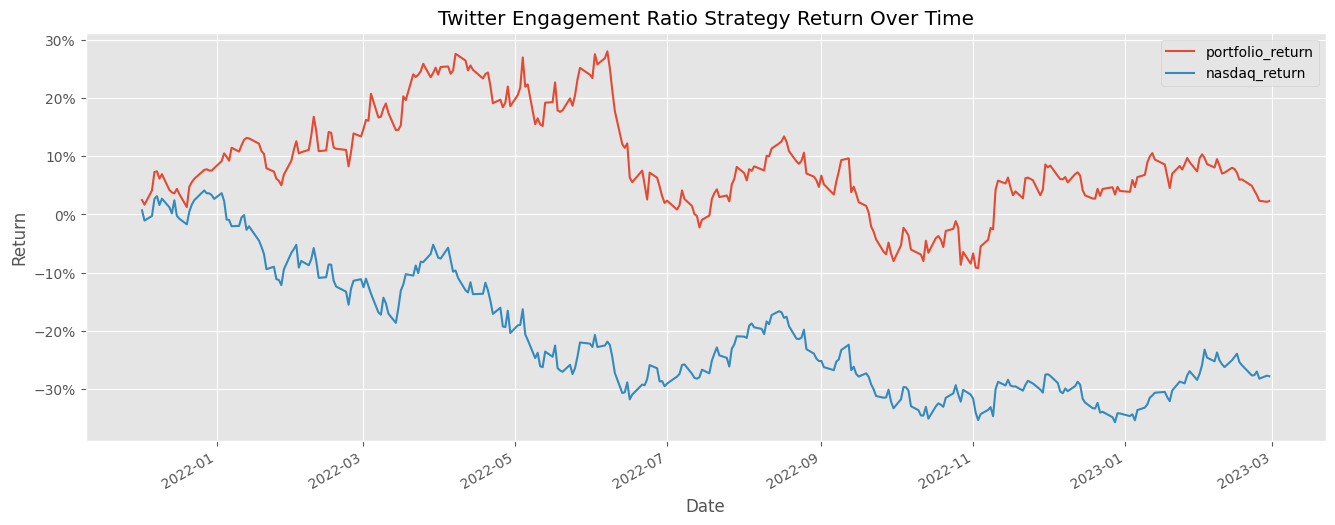

In [84]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()